In [36]:
import mlflow
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns


from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

## Initializing the MLflow Client

In [37]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

In [38]:
all_experiments = mlflow.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1708932190774, experiment_id='0', last_update_time=1708932190774, lifecycle_stage='active', name='Default', tags={}>]


## Create experiment

In [39]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

In [40]:
experiment_id = get_or_create_experiment("Obesity Prediction")
print(experiment_id)

994266685072118732


## Set up MLflow - Initialisation

In [41]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/994266685072118732', creation_time=1708938814113, experiment_id='994266685072118732', last_update_time=1708938814113, lifecycle_stage='active', name='Obesity Prediction', tags={}>

## Data preprocessing

In [42]:
train = pd.read_csv("../data/processed/train.csv")
test = pd.read_csv("../data/processed/test.csv")

target = "NObeyesdad"
random_state = 0

X = train.drop([target], axis=1)
y = train[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

## Hyperparameter Tuning and Model Training using Optuna and MLflow

In [43]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [44]:
# define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'


def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (
                abs(winner - study.best_value) / study.best_value
            ) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(
                f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}"
            )

In [45]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define parameters to be optimized for the LGBMClassifier
        params = {
            "objective": "multiclass",
            "metric": "multi_logloss",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "random_state": random_state,
            "num_class": 7,
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
            "n_estimators": trial.suggest_int("n_estimators", 400, 600),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
            "max_depth": trial.suggest_int("max_depth", 6, 14),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
            "subsample": trial.suggest_float("subsample", 0.8, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        }

        # Train LightGBM model
        model = LGBMClassifier(**params)
        model.fit(X_train, y_train)
        score = model.score(X_valid, y_valid)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("Mean accuracy", score)

    return score

In [46]:
run_name = "1_optuna_lgbm_no_feature_engineering_50_trials"

In [49]:
def plot_feature_importance(model, X=X):
    """
    Plots feature importance for a LightGBM model.

    Args:
    - model: A trained LightGBM model

    Returns:
    - fig: The matplotlib figure object
    """

    fig, ax = plt.subplots(figsize=(12, 10))

    feature_importance = model.feature_importances_
    feature_importance_df = pd.DataFrame(
        {"Feature": X.columns, "Importance": feature_importance}
    )
    feature_importance_df = feature_importance_df.sort_values(
        by="Importance", ascending=False
    )

    sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
    ax.set_title("Feature Importance")
    ax.set_xlabel("Importance")
    ax.set_ylabel("")
    sns.despine(left=True, bottom=True)

    return fig

Initial trial 0 achieved value: 0.915517618734953
Trial 1 achieved value: 0.9133289560078792 with  0.2396% improvement
{'learning_rate': 0.04668856126753902, 'n_estimators': 417, 'lambda_l1': 0.013407636294794096, 'lambda_l2': 0.05812173846271454, 'max_depth': 9, 'colsample_bytree': 0.3468096120953184, 'subsample': 0.9510055126840768, 'min_child_samples': 13}
[LightGBM] [Warning] lambda_l1 is set=0.013407636294794096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013407636294794096
[LightGBM] [Warning] lambda_l2 is set=0.05812173846271454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05812173846271454
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.013407636294794096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013407636294794096
[LightGBM] [Warning] lambda_l2 is set=0.05812173846271454, reg_lambda=0.0 will be ignored. Current

TypeError: save_model() got an unexpected keyword argument 'model_format'

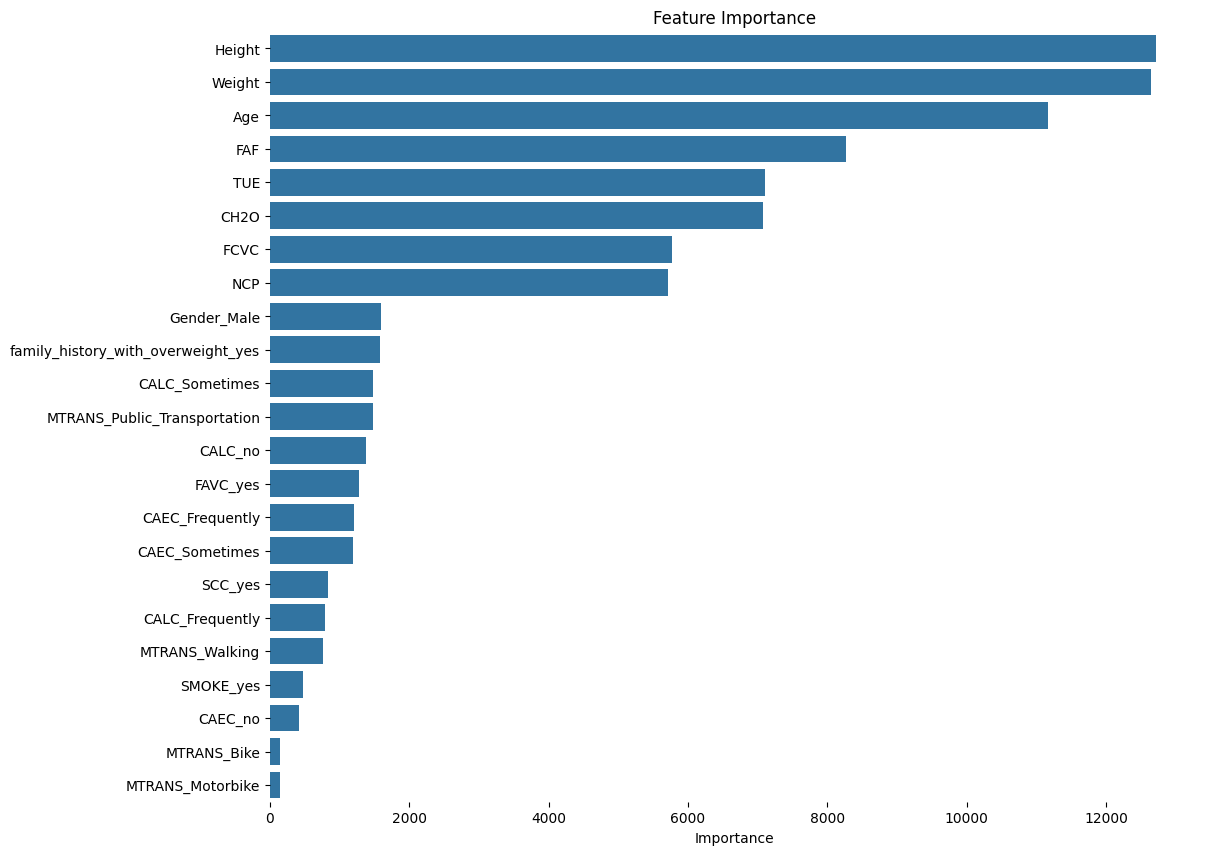

In [51]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Initialize the Optuna study
    study = optuna.create_study(direction="minimize")

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    study.optimize(
        objective,
        n_trials=10,
        callbacks=[champion_callback],
    )

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_accuracy", study.best_value)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Obesity Prediction Project",
            "optimizer_engine": "optuna",
            "model_family": "lightGBM",
            "feature_set_version": 1,
        }
    )

    # Log a fit model instance
    model = LGBMClassifier(**study.best_params)
    print(study.best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    # Log the feature importances plot
    importances = plot_feature_importance(
        model, X=X
    )
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

    artifact_path = "model"

    mlflow.lightgbm.log_model(
        lgb_model=model,
        artifact_path=artifact_path,
        input_example=X_train.iloc[[0]],
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)

In [ ]:
model_uri